In [1]:
%pylab inline
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import time, sys
from IPython.display import clear_output
from scipy import stats
import scipy.stats
import scipy.optimize as opt
# %load_ext jupyternotify


Populating the interactive namespace from numpy and matplotlib


In [2]:
#define F-test function
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f,p
# We have functions to convert proportion correct to z scores and vice versa
def ztop(z):
    p=0.5 * (1.0+scipy.special.erf(z/np.sqrt(2) ) )
    return p

def ptoz(p):
    if p==1:
        p=0.9999999
    elif p==0:
        p=0.0000001
    z=np.sqrt(2) * scipy.special.erfinv( 2*p-1.0)
    return z

def ptozM(p,M=10):
    if p==1:
        p=0.999999
    elif p==0:
        p=0.0001
    # from JEK Smith 1982. Checked to match tables of Hacker/Ratcliff
    K_M=0.86-0.085 * np.log(M-1)
    d=K_M*np.log( (M-1)*p/(1-p) )
    return d

# Function for getting bootstrapped zscores
def bootstrap_corr_to_z(df):
    num_boot=1000
    z_scores=[]
    for i in range(num_boot):
        resampled_df=df.sample(len(df),replace=True)
        zVal=ptozM(resampled_df.mean())
        z_scores.append(zVal)
    return z_scores

# Function for getting bootstrapped prop values from 0/1 correct/incorrect response list
def bootstrap_corr_to_propCor(df):
    num_boot=1000
    propCor=[]
    for i in range(num_boot):
        resampled_df=df.sample(len(df),replace=True)
        propCor.append(resampled_df.mean())
    return propCor

## Perumutation Test
def perm_test(c,t,num_perm,method='mean',z_score=True,*args):
    k=[]
    # Look if there are additional groups passed in
    if len(args)>1:
        t1=args[0]
        t2=agrs[1]
                
    if method=='mean':
        if z_score==True:
            diff=(ptozM(np.mean(c))-ptozM(np.mean(t)))
        else:
            diff=((np.mean(c))-(np.mean(t)))
        z=np.concatenate([c,t])
        for i in range(num_perm):
            np.random.shuffle(z)
            # Since the number of samples in each group is unequal we would match the
            # distribution to the individual lengths of each data series
            if z_score==True:
                k.append((ptozM(np.mean(z[:int(len(c))])) - ptozM(np.mean(z[int(len(c)):]))))  
            else:
                k.append(((np.mean(z[:int(len(c))])) - (np.mean(z[int(len(c)):]))))  
        
    elif method=='ttest':
        # Compare between two sets of measures/data
        diff=stats.ttest_ind(c,t).statistic
        z=np.concatenate([c,t])
        for i in range(num_perm):
            np.random.shuffle(z)
            # Since the number of samples in each group is unequal we would match the
            # distribution to the individual lengths of each data series
            tval=stats.ttest_ind(z[:int(len(c))],z[int(len(c)):])
            k.append(tval.statistic)
        
    elif method=='ftest':
        for arg in args:
            t2=arg
        if 't2' in locals():
            # Compare between more than two sets of measures/data
            diff,p_val=stats.f_oneway(c,t,t2).statistic
            z=np.concatenate([c,t,t2])
            for i in range(num_perm):
                np.random.shuffle(z)
                # Since the number of samples in each group is unequal we would match the
                # distribution to the individual lengths of each data series
                g1=z[:int(len(c))]
                g2=z[int(len(c)):(int(len(c))+int(len(t)))]
                g3=z[(int(len(c))+int(len(t))):]
                fval=stats.f_oneway(g1,g2,g3).statistic
                k.append(fval)
        else:
            # Compare between  two sets of measures/data
            diff,p_val=f_test(c,t)
            z=np.concatenate([c,t])
            for i in range(num_perm):
                np.random.shuffle(z)
                # Since the number of samples in each group is unequal we would match the
                # distribution to the individual lengths of each data series
                g1=z[0:int(len(c))]
                g2=z[int(len(c))::]
                fval,p_val=f_test(g1,g2)
                k.append(fval)
        
    elif method=='friedman':
        # compare between two sets of measures/data
        diff=stats.friedmanchisquare(c,t,t1,t2).statistic
        z=np.concatenate([c,t,t1,t2])
        for i in range(num_perm):
            np.random.shuffle(z)
            # Since the number of samples in each group is unequal we would match the
            # distribution to the individual lengths of each data series
            len_df=len(c) # since lengths of groups are the same we use one of them
            g1=z[0:len_df]
            g2=z[len_df*1:len_df*2]
            g3=z[len_df*2:len_df*3]
            g4=z[len_df*3:len_df*4]
            friedman_test=stats.friedmanchisquare(g1,g2,g3,g4)
            k.append(friedman_test.statistic)
    if method=='mean':
        if diff>0: # when the original difference is positive
            p_value=len(np.where(k>=diff)[0])/num_perm
        elif diff<0: # when the original difference is negative
            p_value=len(np.where(k<=diff)[0])/num_perm
        elif diff==0 and np.mean(k)>0: # when the original difference is zero and distribution is positive
            p_value=len(np.where(k<=diff)[0])/num_perm
        elif diff==0 and np.mean(k)<0:# when the original difference is zero and distribution is negative
            p_value=len(np.where(k>=diff)[0])/num_perm
        else:# It wouldnt normally get here but just to prevent bugs
            p_value=1
    else: # all other test statistic
        if diff<np.mean(k):
            p_value=len(np.where(k<=diff)[0])/num_perm
        elif diff>np.mean(k):
            p_value=len(np.where(k>=diff)[0])/num_perm
    
    # check if p_value exists, if not assign it a high value
    if 'p_value' not in locals():
        print('UnboundLocalError')
        p_value=1
    
            
    return {"diff":diff,"k":k,'p_val':p_value}

# GENERAL EQUATION ------------------------------------------------------------
#1. We use an exponential fit
#2. Or we use a weibull fit
def func(x, A, c, d):
    return A*np.exp(c*x) + d
# Wikipedia Weibull CDF https://en.wikipedia.org/wiki/Weibull_distribution
def func_weibull(x,lamb,k,lr):
    guess=0.25
    weibull_cdf=(1-np.exp(- (x/lamb)**k) )
    yval=guess+(1.0-guess-lr)*weibull_cdf
    return yval

In [ ]:
if sys.platform=='win32':
#     data_directory='Z:\TSLO_Experiment\VoluntaryMicrosaccade\Experiment2ObliqueMicrosaccadeWNeutral'
    data_directory='Z:\\TSLO_Experiment\\VoluntaryMicrosaccade\\Experiment1HorizontalMicrosaccade'
elif sys.platform=='linux':
    data_directory='/home/coateslab/LabData/TSLO_Experiment/VoluntaryMicrosaccade/Experiment1AllFlankers/'
filedir_list=[]
for root,dirs,file in os.walk(data_directory):
    if "Videos" in root and "Processed" not in root and "Pilot" not in root and "Training" not in root:
        filedir_list.append(root)

behav_compile=True
if behav_compile==True:
    # we get the path for the inidividual behavioral data files
    if sys.platform=='win32':
        behavdata_dir='Z:\\TSLO_Experiment\\VoluntaryMicrosaccade\\Experiment1HorizontalMicrosaccade'
    elif sys.platform=='linux':
        behavdata_dir='/home/coateslab/LabData/TSLO_Experiment/VoluntaryMicrosaccade/Experiment1AllFlankers/'
    behavdir_list=[]
    for root,dirs,file in os.walk(behavdata_dir):
        if "Behav"in root and "Pilot" not in root and "Training" not in root:
            behavdir_list.append(root)
        
# Saccade data compilation
# % time
# This cell compiles the saccade metrics obtained from the ReVAS eye position filters and saccade(and drift) detection functions
# In this case we obtain the saccade and drift metrics from the mat files that are created by ReVAS
failedMicroSacc=[]
microSaccData=[]
driftData=[]
create_pickle= False
# while create_dataframe==True:
num_elements=len(filedir_list)
counter=0
for foldername in filedir_list:
    update_progress(counter/num_elements)
    counter+=1
    failedMicroSacc=os.listdir(foldername)
    filelist=os.listdir(foldername)
    subj_id=foldername[foldername.find("S0"):(foldername.find("S0")+3)]
    for filename in filelist:
        if 'sacsdrifts' in filename:
            #try:
            # First we load the mat file into jupyter
            mat=scipy.io.loadmat(os.path.join(foldername,filename))
            # we get the foldername from the filepath
#             folderdate=foldername.replace('/mnt/hd/ao/vids/','')
            # initially we create empty pandas dataframes
            tempSaccData=pd.DataFrame({'Duration':[],'onsetIdx':[],'offsetIdx':[],'onsetTime':[],'offsetTime':[],'xAmp':[],'yAmp':[]\
                                        ,'VectorAmp':[],'Direction':[],'peakVel':[],'meanVel':[]})
            # 1. form saccade dataset for the file
            if len((mat['params']['saccades'][0,0]))==0 or (mat['params']['saccades'][0,0].size)==0:
                tempSaccData=tempSaccData.append({'Duration':np.nan,'onsetIdx':np.nan,'offsetIdx':np.nan,'onsetTime':np.nan,\
                                                    'offsetTime':np.nan,'xAmp':np.nan,'yAmp':np.nan,\
                                                    'VectorAmp':np.nan,'Direction':np.nan,'peakVel':np.nan,'meanVel':np.nan},ignore_index=True)
            else:
                # we determine the size of the saccade array
                tempSaccData=pd.DataFrame({'Duration':[],'onsetIdx':[],'offsetIdx':[],'onsetTime':[],'offsetTime':[],'xAmp':[],'yAmp':[]\
                                        ,'VectorAmp':[],'Direction':[],'peakVel':[],'meanVel':[]})

                saccArraySize=mat['params']['saccades'][0,0]['duration'].size # for now use one of the fields of the struct array
                durationList=[]
                onsetIdxList=[]
                offsetIdxList=[]
                onsetTimeList=[]
                offsetTimeList=[]
                xAmpList=[]
                yAmpList=[]
                VectorAmpList=[]
                DirectionList=[]
                peakVelList=[]
                maxVelList=[]
                for itemIdx in range(saccArraySize): #here we would want to unapack each item from the struct and append it to a list 
                    duration=(mat['params']['saccades'][0,0]['duration'][itemIdx].flatten().item().item())
                    onsetIdx=(mat['params']['saccades'][0,0]['onsetIndex'][itemIdx].flatten().item().item())
                    offsetIdx=(mat['params']['saccades'][0,0]['offsetIndex'][itemIdx].flatten().item().item())
                    onsetTime=((mat['params']['saccades'][0,0]['onsetTime'][itemIdx].flatten().item().item()))
                    offsetTime=(mat['params']['saccades'][0,0]['offsetTime'][itemIdx].flatten().item().item())
                    xAmp=(mat['params']['saccades'][0,0]['xAmplitude'][itemIdx].flatten().item().item())
                    yAmp=(mat['params']['saccades'][0,0]['yAmplitude'][itemIdx].flatten().item().item())
                    VectorAmp=(mat['params']['saccades'][0,0]['vectorAmplitude'][itemIdx].flatten().item().item())
                    Direction=(mat['params']['saccades'][0,0]['direction'][itemIdx].flatten().item().item())
                    peakVel=(mat['params']['saccades'][0,0]['peakVelocity'][itemIdx].flatten().item().item())
                    maxVel=(mat['params']['saccades'][0,0]['meanVelocity'][itemIdx].flatten().item().item())

                    tempSaccData=tempSaccData.append({'Duration':duration,'onsetIdx':onsetIdx,'offsetIdx':offsetIdx,'onsetTime':onsetTime,\
                                'offsetTime':offsetTime,'xAmp':xAmp,'yAmp':yAmp,'VectorAmp':VectorAmp,'Direction':Direction\
                                ,'peakVel':peakVel,'meanVel':maxVel},ignore_index=True)
            # We finally add file details to the data structure which can later be used to 
            # query into the dataframe
            tempSaccData['filename']=filename
            trialCode='%s'%(filename[0:filename.find('_Video')])
            if "_2.5_" in trialCode:
                trialCode=trialCode.replace("_2.5_","_2.50_")
            tempSaccData['code']=trialCode
            tempSaccData['subj_id']=subj_id
            if 'NoMicrosaccade' in filename:
                tempSaccData['microsaccade_cond']='NoMicrosaccade'
            else:
                tempSaccData['microsaccade_cond']='Microsaccade'
#             tempSaccData['foldername']=folderdate
#             tempSaccData['code']='%s_%s'%(folderdate,filename[0:filename.find('_Eye')])
            #The temporary data is then appended to the bigger data structure 
            microSaccData.append(tempSaccData)
            #except:
                #failedMicroSacc.append(os.path.join(foldername,filename))
# create_dataframe=True
microSaccData=pd.concat(microSaccData)
# we then remove the saccade data with NaNs
microSaccFiltered=microSaccData[microSaccData['Direction'].notnull()]

# Drift data compilation
# % time
# This cell compiles the saccade metrics obtained from the ReVAS eye position filters and saccade(and drift) detection functions
# In this case we obtain the saccade and drift metrics from the mat files that are created by ReVAS
failedDrifts=[]
driftData=[]
create_pickle= False
# while create_dataframe==True:
num_elements=len(filedir_list)
counter=0
for foldername in filedir_list:
    update_progress(counter/num_elements)
    counter+=1
    failedMicroSacc=os.listdir(foldername)
    filelist=os.listdir(foldername)
    subj_id=foldername[foldername.find("S0"):(foldername.find("S0")+3)]
    for filename in filelist:
        if 'sacsdrifts' in filename:
            try:
                # First we load the mat file into jupyter
                mat=scipy.io.loadmat(os.path.join(foldername,filename))
                # we get the foldername from the filepath
    #             folderdate=foldername.replace('/mnt/hd/ao/rotVids/','')
                # initially we create empty pandas dataframes
                tempDriftData=pd.DataFrame({'Duration':[],'onsetIdx':[],'offsetIdx':[],'onsetTime':[],'offsetTime':[],'xAmp':[],'yAmp':[]\
                                           ,'VectorAmp':[],'Direction':[],'peakVel':[],'meanVel':[]})
                # 1. form saccade dataset for the file
                if len((mat['params']['drifts'][0,0]))==0 or (mat['params']['drifts'][0,0].size)==0:
                    tempDriftData=tempSaccData.append({'Duration':np.nan,'onsetIdx':np.nan,'offsetIdx':np.nan,'onsetTime':np.nan,\
                                                      'offsetTime':np.nan,'xAmp':np.nan,'yAmp':np.nan,\
                                                      'VectorAmp':np.nan,'Direction':np.nan,'peakVel':np.nan,'meanVel':np.nan},ignore_index=True)
                else:
                    # we determine the size of the saccade array
                    tempSaccData=pd.DataFrame({'Duration':[],'onsetIdx':[],'offsetIdx':[],'onsetTime':[],'offsetTime':[],'xAmp':[],'yAmp':[]\
                                           ,'VectorAmp':[],'Direction':[],'peakVel':[],'meanVel':[]})

                    driftArraySize=mat['params']['drifts'][0,0]['duration'].size # for now use one of the fields of the struct array
                    durationList=[]
                    onsetIdxList=[]
                    offsetIdxList=[]
                    onsetTimeList=[]
                    offsetTimeList=[]
                    xAmpList=[]
                    yAmpList=[]
                    VectorAmpList=[]
                    DirectionList=[]
                    peakVelList=[]
                    maxVelList=[]
                    for itemIdx in range(driftArraySize): #here we would want to unapack each item from the struct and append it to a list 
                        duration=(mat['params']['drifts'][0,0]['duration'][itemIdx].flatten().item().item())
                        onsetIdx=(mat['params']['drifts'][0,0]['onsetIndex'][itemIdx].flatten().item().item())
                        offsetIdx=(mat['params']['drifts'][0,0]['offsetIndex'][itemIdx].flatten().item().item())
                        onsetTime=((mat['params']['drifts'][0,0]['onsetTime'][itemIdx].flatten().item().item()))
                        offsetTime=(mat['params']['drifts'][0,0]['offsetTime'][itemIdx].flatten().item().item())
                        xAmp=(mat['params']['drifts'][0,0]['xAmplitude'][itemIdx].flatten().item().item())
                        yAmp=(mat['params']['drifts'][0,0]['yAmplitude'][itemIdx].flatten().item().item())
                        VectorAmp=(mat['params']['drifts'][0,0]['vectorAmplitude'][itemIdx].flatten().item().item())
                        Direction=(mat['params']['drifts'][0,0]['direction'][itemIdx].flatten().item().item())
                        peakVel=(mat['params']['drifts'][0,0]['peakVelocity'][itemIdx].flatten().item().item())
                        maxVel=(mat['params']['drifts'][0,0]['meanVelocity'][itemIdx].flatten().item().item())

                        tempDriftData=tempDriftData.append({'Duration':duration,'onsetIdx':onsetIdx,'offsetIdx':offsetIdx,'onsetTime':onsetTime,\
                                  'offsetTime':offsetTime,'xAmp':xAmp,'yAmp':yAmp,'VectorAmp':VectorAmp,'Direction':Direction\
                                  ,'peakVel':peakVel,'meanVel':maxVel},ignore_index=True)
                # We finally add file details to the data structure which can later be used to 
                # query into the dataframe
                tempDriftData['filename']=filename
                trialCode='%s'%(filename[0:filename.find('_Video')])
                if "_2.5_" in trialCode:
                    trialCode=trialCode.replace("_2.5_","_2.50_")
                tempSaccData['code']=trialCode
                tempDriftData['subj_id']=subj_id
                if 'NoMicrosaccade' in filename:
                    tempDriftData['microsaccade_cond']='NoMicrosaccade'
                else:
                    tempDriftData['microsaccade_cond']='Microsaccade'
    #             tempDriftData['foldername']=folderdate
    #             tempDriftData['code']='%s_%s'%(folderdate,filename[0:filename.find('_Eye')])

                #The temporary data is then appended to the bigger data structure 
                driftData.append(tempDriftData)
            except:
                failedMicroSacc.append(os.path.join(foldername,filename))
#     create_dataframe=False
driftData=pd.concat(driftData)
# we then remove the saccade data with NaNs
driftDataFiltered=driftData[driftData['Direction'].notnull()]
  

if behav_compile==True:
    # Behav Data compilation
    behavdir_listles=[]
    behavData=[]
    questData=[]

    num_elements=len(behavdir_list)
    for foldername in behavdir_list:
        # we find subject ID
        subj_id=foldername[foldername.find('S0'):foldername.find('S0')+3]
        filelist=os.listdir(foldername)
        for filename in filelist:
            try:
                if 'Crowding' in filename and 'CrowdingQuest' not in filename and 'CrowdingThresh' not in filename:
                    # First we load the mat file into jupyter
                    tempBehav=pd.read_csv(os.path.join(foldername,filename))
                    tempBehav['filename']=filename
                    if "NoMicrosaccade"  in filename:
                        tempBehav['microsaccade_cond']='NoMicrosaccade'
                        trialCode='%s'%(filename[0:filename.find('_NoMicrosaccade')])
                    else:
                        tempBehav['microsaccade_cond']='Microsaccade'
                        trialCode='%s'%(filename[0:filename.find('_Crowding')])               
                    tempBehav['code']=trialCode
                    tempBehav['subj_id']=subj_id
                    #The temporary data is then appended to the bigger data structure 
                    behavData.append(tempBehav)
                elif "CrowdingThresh" in filename:
                    #We again load data into jupyter
                    tempData=pd.read_csv(os.path.join(foldername,filename))
                    tempData['subj_id']=subj_id
                    # ///rly we build the dataframe
                    questData.append(tempData)
            except:
                print(filename)
    if len(questData)!=0:
        questData=pd.concat(questData)
    behavData=pd.concat(behavData)
    
    
# Marker data compilation
failedFiles=[]
markerData=[]
markerFixNeeded=False
# while create_dataframe==True:
counter=0
num_elements=len(filedir_list)
for foldername in filedir_list:
#     update_progress(counter/num_elements)
    counter+=1
    filelist=os.listdir(foldername)
    subj_id=foldername[foldername.find("S0"):(foldername.find("S0")+3)]
    for filename in filelist:
        if 'marker' in filename and 'markerData' not in filename:
            # First we load the mat file into jupyter
            tempData=pd.read_csv(os.path.join(foldername,filename),names=['frameIdx','stripIdx'])
            tempData['stimulusOnsetTime']=(tempData['frameIdx']*(1000/30)/1000)+(tempData['stripIdx']*(1000/16000)/1000)
            if markerFixNeeded==True:
                if len(tempData)!=2: # Cases where marker is missing we get values from behav data
                    if "NoMicrosaccade" in filename:
                        trialCode='%s'%(filename[0:filename.find('_Video')])
                    else:
                        trialCode='%s'%(filename[0:filename.find('_Microsaccade')])
                    # Get this from the marker file, since the first marker would correspond to the cue onset. 
                    # The second missing one would correspond to the target onset
                    if len(tempData)>0:
                        cueOnsetTime=tempData['stimulusOnsetTime'].iloc[0]
                        # We get the behavioral data from the trial
                        behavDataTrial=behavData.query("code==@trialCode")
                        if len(behavDataTrial)>0: # valid ones
                            # We get this from behavioral data
                            cueDuration=behavDataTrial['cueDuration'].iloc[0]
                            # Using the two we figure out when the target happened
                            targetOnsetTime=cueOnsetTime+cueDuration
                            # We create a df with dummy strip values & calculation target onset time
                            markerFix=pd.DataFrame([[np.nan,np.nan,targetOnsetTime]],columns=['frameIdx','stripIdx','stimulusOnsetTime'])
                            # We finally append this to existing marker data
                            tempData=tempData.append(markerFix)


            tempData['filename']=filename
            tempData['code']='%s'%(filename[0:filename.find('_Video')])

            tempData['subj_id']=subj_id
            if 'NoMicrosaccade' in filename:
                tempData['microsaccade_cond']='NoMicrosaccade'
            else:
                tempData['microsaccade_cond']='Microsaccade'
            #The temporary data is then appended to the bigger data structure 
            markerData.append(tempData)
            
markerData=pd.concat(markerData)

In [10]:
data_dir='D:\\KSP\\Study\\Houston\\Projects\\TSLOExperiments\\TSLOData\\CrowdingVoluntaryMicrosaccade\\Experiment1_rightward\\Data'

os.chdir(data_dir)
microSaccFiltered=pd.read_csv('saccData.csv')
driftData=pd.read_csv('driftData.csv')
#eyepos=pd.read_pickle('eyepos.pkl')
markerData=pd.read_csv('markerData.csv')
behavData=pd.read_csv('behavData.csv')
relSaccData=pd.read_csv("relSaccData.csv")
fit_paramsDF=pd.read_csv("fit_paramsDF.csv")
y_model_df.to_csv("y_model_df.csv")

# Exclude S06
microSaccFiltered=microSaccFiltered.query("subj_id!='S06'")
driftData=driftData.query("subj_id!='S06'")
markerData=markerData.query("subj_id!='S06'")
behavData=behavData.query("subj_id!='S06'")
relSaccData=relSaccData.query("subj_id!='S06'")


## Fixation stability & its effect on behavioral performance
### Here we look at BCEA prior to stimulus onset

In [ ]:
"#calculating BCEA (68% confidence ellispe)\n",
def CalcBCEA(xdata,ydata):
    rho=np.corrcoef( xdata, ydata)[0,1]
    bcea=2 * 2.291/2.0 * np.pi * np.std(xdata) * np.std(ydata) * np.sqrt(1-rho**2)
    return bcea

In [22]:
codelist=eyepos['code'].unique()
bceaList_precue=[]
bceaList_prestim=[]
codeList=[]
counter=0
total_iter=len(codelist)-1
for acode in codelist:
    print('%d/%d' %(counter,total_iter),end='\r')
    try:
        #Marker data
        tempMarker=markerData.query("code==@acode")
        cueTime=tempMarker['stimulusOnsetTime'].iloc[0]
        stimTime=tempMarker['stimulusOnsetTime'].iloc[1]
        trialPosPreCue=eyepos.query("code==@acode and time<@cueTime")
        trialPosPreStim=eyepos.query("code==@acode and time<@stimTime")
        bceaValPreCue=CalcBCEA(trialPosPreCue['xpos'],trialPosPreCue['ypos'])
        bceaValPreStim=CalcBCEA(trialPosPreStim['xpos'],trialPosPreStim['ypos'])
        bceaList_precue.append(bceaValPreCue)
        bceaList_prestim.append(bceaValPreStim)
        codeList.append(codeList)
        counter+=1
    except IndexError:
        print('Marker Error!')
bceaDF=pd.DataFrame(np.column_stack((bceaList_precue,bceaList_prestim,codeList)),columns=['bcea_preCue','bcea_preStim','code'])
bceaDFmerged=pd.merge(bceaDF,behavData,left_on='code',right_on='code')

KeyboardInterrupt: 

In [ ]:
sns.barplot(x='corr',y='bcea_preStim',data=bceaDFmerged)

## Stimulus data relative to saccade onset time
### Here we also look at the associated behavioral performance

In [11]:
#Compiles microsaccades that occurs following the last stimulus onset
codeList=microSaccFiltered['code'].unique()
relSaccData=[]
relStimTime=[]
relSacc=[]
for acode in codeList:
    try:
        lastStimTime=markerData.query("code==@acode")['stimulusOnsetTime'].iloc[1]
        # get only saccades that occur after final stimulus
        # We try to get only the first microsaccade that occurs after stimulus onset
        tempSacc=microSaccFiltered.query("code==@acode & @lastStimTime<onsetTime<(@lastStimTime+0.600) & VectorAmp>0.15")
        if len(tempSacc)>0:
            sacc=tempSacc['onsetTime'].iloc[0]
            relSaccTime=sacc-lastStimTime
            relSacc.append(relSaccTime)
        tempSacc['lastStimTime']=lastStimTime
        tempSacc['relOnsetTime']=tempSacc['onsetTime']-lastStimTime
        # get stimulus time relative to saccade onset
        if len(tempSacc)>0:
            saccOnsetTime=tempSacc['onsetTime'].iloc[0]
            relStimOnsetTime=lastStimTime-saccOnsetTime
            relStimTime.append(relStimOnsetTime)
        tempSacc['relStimTime']=relStimOnsetTime
        # we add only the first microsaccade to the saccade array
        relSaccData.append(tempSacc.head(1))
    except (IndexError,NameError) as e:
        pass
relSaccData=pd.concat(relSaccData)


c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [12]:
## Filter trials based on microsaccadic activity\n",

#A temoporal cut-off is set & trials with micrsaccades in that time window are grouped as trials with microsaccades & the rest as trials without microsaccades
# We set the value that would be used to distinguish between saccade & no saccade trials
# no microsaccade trials
behavDataNoMicrosaccadeWsaccades=list(behavData.query("microsaccade_cond=='NoMicrosaccade'")['code'])
NoMicroSaccadeFailedTrial=relSaccData.query("code==@behavDataNoMicrosaccadeWsaccades and relStimTime>-0.300")['code']
behavDataNoMicrosaccade=behavData[behavData.code.isin(behavDataNoMicrosaccadeWsaccades)]
# saccade Trials
behavDataSaccadeList=list(behavData.query(" microsaccade_cond=='Microsaccade'")['code'])
saccadeTrials=relSaccData.query("code==@behavDataSaccadeList")
saccadeData=pd.merge(saccadeTrials,behavData,left_on='code',right_on='code',copy=False)

# The saccade directions range from -180 to +180 and uses the atan2d function in matlab. So to retrieve values that range between 0 and 360 we add 360 for values that\n",
# are below 0
saccadeData['DirectionPolar']=0
for i in range(len(saccadeData)):
    if saccadeData['Direction'].iloc[i]<0:
        saccadeData['DirectionPolar'].iloc[i]=saccadeData['Direction'].iloc[i]+360
    else:
        saccadeData['DirectionPolar'].iloc[i]=saccadeData['Direction'].iloc[i]



## Filter task relevant microsaccades

In [13]:
## Filter task relevant microsaccades
# Filter saccade data based on relative stimulus onset time
sacc300msOnsetDF=saccadeData.query("relStimTime>-0.300")
#Filter saccade based on direction
sacc_LR=sacc300msOnsetDF.query("270<DirectionPolar<360")
sacc_UR=sacc300msOnsetDF.query("0<DirectionPolar<90")
sacc300msOnsetDF=pd.concat([sacc_UR,sacc_LR])


## Microsaccade direction

c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_tight" which is no longer supported as of 3.3 and will become an error two minor releases later
  from ipykernel import kernelapp as app


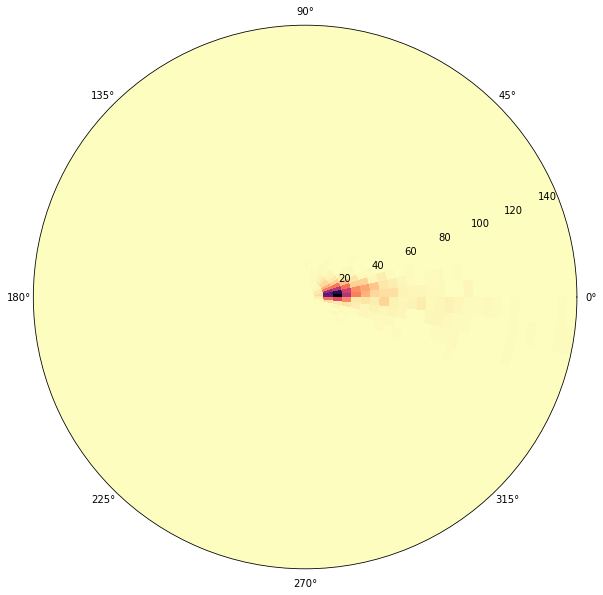

In [14]:
df=sacc300msOnsetDF
arr=np.radians(df['DirectionPolar'])
radius=df['VectorAmp']*60

# define binning
rbins = np.linspace(0,radius.max(), 30)
abins = np.linspace(0,2*np.pi, 60)
#calculate histogram
hist, _, _ = np.histogram2d(arr, radius, bins=(abins, rbins))
A, R = np.meshgrid(abins, rbins)

fig,ax=plt.subplots(1,1,subplot_kw={'projection':'polar'},figsize=(10,10))
pc = ax.pcolormesh(A, R, hist.T, cmap="magma_r")

plt.savefig("..\Plots\MicrosaccadeDirection.svg",dpi=1200,bbox_tight='inches')

## Stimulus onset frequency distribution relative to saccade onset

c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_tight" which is no longer supported as of 3.3 and will become an error two minor releases later
  


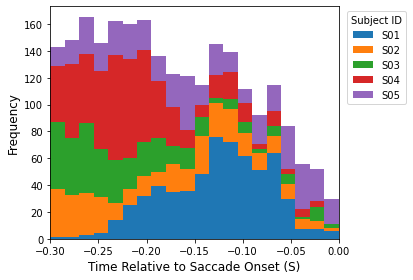

In [17]:
df=sacc300msOnsetDF
plt.hist([df.query("subj_id_x=='S01'")['relStimTime'],df.query("subj_id_x=='S02'")['relStimTime'],df.query("subj_id_x=='S03'")['relStimTime'],df.query("subj_id_x=='S04'")['relStimTime'],df.query("subj_id_x=='S05'")['relStimTime']],stacked=True,bins=20,label=['S01','S02','S03','S04','S05'])
plt.legend(title='Subject ID',bbox_to_anchor=(1.25,1))
plt.xlabel("Time Relative to Saccade Onset (S)",size=12)
plt.ylabel("Frequency",size=12)
plt.tight_layout()
plt.xlim(-0.3,0)
plt.savefig("..\Plots\stimuliOnsetRelativetoSaccade.svg",dpi=1200,bbox_tight='inches')

## Psychometric functions

In [20]:
# we do the same thing as earlier but for each subject individually and create a df with critical spacings
# First step is to get a function
# Have a function that pulls in the X & Y values from df, fits the data and get the Critical spacing
def fit_and_get_CS(df,x_lin):
    # First sort the x & y values from the DF
    x_all=df['spacing'].unique()
    y_all=df.groupby('spacing')['corr'].mean().values
    x_all.sort()
    y_all.sort()
    #optimize fit 
    p0 = [3.5, 2,0.05] 
    w,_=opt.curve_fit(func_weibull,x_all,y_all,p0=p0,bounds=(0,[10, 10,0.5]),maxfev=10000)
    # model fit
    y_model=func_weibull(x_lin,*w)
    # Compute Critical Spacing (CS)
    CS=np.interp(0.75*np.max(y_model), y_model,x_lin)
    # Also add interpolated 50% of asymptotic level
    fifty_percent_interp=np.interp(0.50*np.max(y_model), y_model,x_lin)
    # return the paramters
    return w,y_model,CS,fifty_percent_interp
# we first create the empty arrays that will be filling inside the loop
y_model_sacc_list=np.array([])
y_model_nosacc_list=np.array([])
x_lin_list=np.array([])
CS_sacc_list=np.array([])
CS_nosacc_list=np.array([])
ecc_array=np.array([])
sub_list=np.array([])
# Get the fit parameters too
w1_lambda_list=np.array([])
w1_k_list=np.array([])
w1_lr_list=np.array([])
w2_lambda_list=np.array([])
w2_k_list=np.array([])
w2_lr_list=np.array([])
w_sub_list=np.array([])
# Create an empty df and fill inside loop
subjs=behavData['subj_id'].unique()
counter=1
ecc_list=behavData.ecc.unique()
for asub in subjs:
    # This plots the psychometric function in trials with and without microsaccades independently
    dataWsacc=sacc300msOnsetDF.query("corr!='NaN' & subj_id_x==@asub & spacing!=1.2") # to fix cases where the rel onset time is really big
    # third we declare data/trials without microsaccades
    dataWOsacc=behavDataNoMicrosaccade.query("corr!='NaN' & subj_id==@asub & spacing!=1.2")

    # We use bootstrapping procedure for each getting the fit for each resampled data 
    for resample_idx in range(1000):
        print('%d/%d'%(counter,5000),end='\r')
        #1. Resample DF
        new_df_sacc = dataWsacc.sample(n=len(dataWsacc),replace=True)
        new_df_nosacc=dataWOsacc.sample(n=len(dataWOsacc),replace=True)
        # Model
        unflanked_position=5
        x_lin=np.linspace(0,unflanked_position,50)
        w1,y_model_sacc,CS_sacc,fifty_percent_interp_sacc = fit_and_get_CS(new_df_sacc,x_lin)
        w2,y_model_nosacc,CS_nosacc,fifty_percent_interp_nosacc=fit_and_get_CS(new_df_nosacc,x_lin)

        # Finally we save it to a DF
        y_model_sacc_list=np.concatenate((y_model_sacc_list,y_model_sacc),axis=None)
        y_model_nosacc_list=np.concatenate((y_model_nosacc_list,y_model_nosacc),axis=None)
        x_lin_list=np.concatenate((x_lin_list,x_lin),axis=None)
        sub_list=np.concatenate((sub_list,np.repeat(asub,len(y_model_sacc))))
        # we append subj id to fit params
        w1_lambda_list=np.concatenate((w1_lambda_list,w1[0]),axis=None)
        w1_k_list=np.concatenate((w1_k_list,w1[1]),axis=None)
        w1_lr_list=np.concatenate((w1_lr_list,w1[2]),axis=None)
        w2_lambda_list=np.concatenate((w2_lambda_list,w2[0]),axis=None)
        w2_k_list=np.concatenate((w2_k_list,w2[1]),axis=None)
        w2_lr_list=np.concatenate((w2_lr_list,w2[2]),axis=None)
        w_sub_list=np.concatenate((w_sub_list,asub),axis=None)
    #         CS_cong_list=np.concatenate((CS_cong_list,CS_cong),axis=None)
    #         CS_incong_list=np.concatenate((CS_incong_list,CS_incong),axis=None)
    #         CS_nosacc_list=np.concatenate((CS_nosacc_list,CS_nosacc),axis=None)
        counter+=1
#create individual df's and append together
# Model DF
y_model_df_nosacc=pd.DataFrame((np.column_stack((x_lin_list,y_model_nosacc_list,sub_list))),columns=['x_lin','y_model','subj'])
y_model_df_nosacc['microsaccade_condition']='no_saccade'
y_model_df_sacc=pd.DataFrame((np.column_stack((x_lin_list,y_model_sacc_list,sub_list))),columns=['x_lin','y_model','subj'])
y_model_df_sacc['microsaccade_condition']='saccade'
frames=[y_model_df_sacc,y_model_df_nosacc]
y_model_df=pd.concat(frames)
y_model_df['x_lin']=y_model_df['x_lin'].astype('float')
y_model_df['y_model']=y_model_df['y_model'].astype('float')

w1_df=pd.DataFrame((np.column_stack((w1_lambda_list,w1_k_list,w1_lr_list,w_sub_list))),columns=['lambda','k','lr','subj'])
w1_df['saccade_cond']='saccade'
w2_df=pd.DataFrame((np.column_stack((w2_lambda_list,w2_k_list,w2_lr_list,w_sub_list))),columns=['lambda','k','lr','subj'])
w2_df['saccade_cond']='no_saccade'
fit_paramsDF=w1_df.append(w2_df)
fit_paramsDF['lambda']=fit_paramsDF['lambda'].astype('float')
fit_paramsDF['k']=fit_paramsDF['k'].astype('float')
fit_paramsDF['lr']=fit_paramsDF['lr'].astype('float')
fit_paramsDF.to_csv("fit_paramsDF.csv")

c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in power


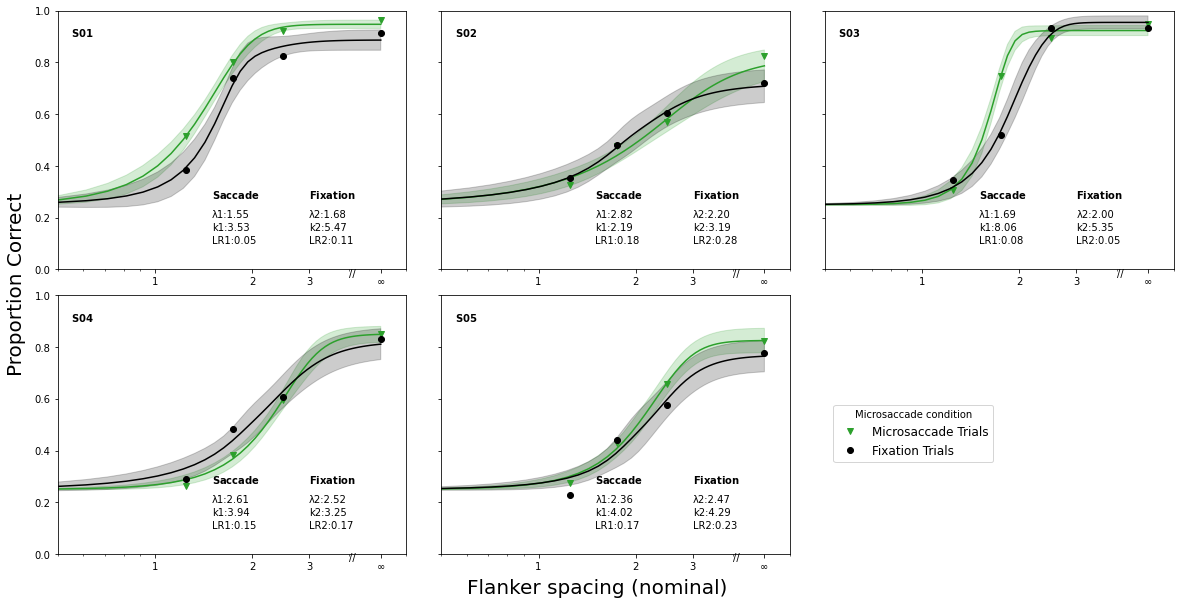

In [22]:

bootstrap_fit=True
subs=behavData.subj_id.unique()
fig,ax=plt.subplots(nrows=2,ncols=3,sharey=True,figsize=(20,10))
subCounter=0
for row in ax:
    for col in row:
        if subCounter!=5:
            asub=subs[subCounter]
            # This plots the psychometric function in trials with and without microsaccades independently
            # Set whether or not to use bootstrap fit
            # First we declare the data/trials with congruent microsaccades
            dataWsacc=sacc300msOnsetDF.query("subj_id_x==@asub") # to fix cases where the rel onset time is really big
            #get samples
            x_all = dataWsacc['spacing'].unique()
            #     x_all.sort()
            y_all = dataWsacc.groupby('spacing')['corr'].mean().values
            x_sacc=x_all#[:-1]
            x_sacc.sort()
            y_sacc=y_all#[:-1]
            y_sacc.sort()

            # second we declare the data/trials without microsaccades
            dataWOsacc=behavDataNoMicrosaccade.query("subj_id==@asub") # to fix cases where the rel onset time is really big
            #get samples
            x_all = dataWOsacc['spacing'].unique()
            #     x_all.sort()
            y_all = dataWOsacc.groupby('spacing')['corr'].mean().values
            x_nosacc=x_all#[:-1]
            x_nosacc.sort()
            y_nosacc=y_all#[:-1]
            y_nosacc.sort()


            # REGRESSION ------------------------------------------------------------------
            p0 = [3.5, 2,0.05] #weibull                                       # guessed params
            #     p0=[-1.5,-1,1] # exponential
            w1, _ = opt.curve_fit(func_weibull, x_sacc, y_sacc, p0=p0)
            w2, _ = opt.curve_fit(func_weibull, x_nosacc, y_nosacc, p0=p0)
        #     print("Estimated Parameters:Saccade", w1)  
        #     print("Estimated Parameters:no saccade", w2)  

            unflanked_position=5
            # Model
            x_lin=np.linspace(0,unflanked_position,50) # we move the unflanked one to 6th pos to make it look nice
            y_model_sacc = func_weibull(x_lin, *w1)
            y_model_nosacc= func_weibull(x_lin, *w2)

            #plot congruent microsaccade condition
        #     sns.pointplot(data=dataWsacc,x='spacing',y='corr',join=False,ax=col,palette=['C2'])
            col.plot(x_sacc[:-1], y_sacc[:-1],ls='',marker='v',color='C2',label='Microsaccade Trials')
            col.plot(unflanked_position,y_sacc[-1], marker='v',color='C2')

            if bootstrap_fit==True:
                sns.lineplot(x='x_lin',y='y_model',color='C2',ci='sd',data=y_model_df.query("microsaccade_condition=='saccade' & subj==@asub"),ax=col)
            else:
                col.plot(x_lin,y_model_sacc,ls='--',color='C2')
            #plot no saccade condtion
        #     sns.pointplot(data=dataWOsacc,x='spacing',y='corr',join=False,ax=col,palette=['k'])
            col.plot(x_nosacc[:-1], y_nosacc[:-1],ls='',marker='o',color='k',label='Fixation Trials')
            col.plot(unflanked_position,y_nosacc[-1],marker='o',color='k')

            if bootstrap_fit==True:
                sns.lineplot(x='x_lin',y='y_model',color='k',ci='sd',data=y_model_df.query("microsaccade_condition=='no_saccade' & subj==@asub"),ax=col)
                col.set_xlabel('')
                col.set_ylabel('')
            else:
                col.plot(x_lin,y_model_nosacc,ls='--',color='k')
            #plot tweaks
            if subCounter==4:
                col.legend(title='Microsaccade condition',bbox_to_anchor=(1.6,0.6), prop={'size': 12})
            else:
                if bootstrap_fit==True:
                    col.get_legend().remove()
            col.set_ylim(0,1)
            col.set_xlim(0.5,6)
            col.set_xscale('log')
            col.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
            col.set_xticks([1,2,3,unflanked_position])
            col.set_xticklabels(['1','2','3','∞'])
            # We add the fit parameters inside the plot
            col.text(col.get_xlim()[0]+0.05,0.90,r"$\bf{%s}$"%asub)
            col.text(4,-0.025,'//')
            first_pos=1.5
            second_pos=3
            if bootstrap_fit==True:
                # we get the fit measures from the bootrapped DF
                w1=fit_paramsDF.query("saccade_cond=='saccade' & subj==@asub").mean()
                w2=fit_paramsDF.query("saccade_cond=='no_saccade' & subj==@asub").mean()
                col.text(first_pos,0.2,"λ1:%.2f"%w1[0])
                col.text(second_pos,0.2,"λ2:%.2f"%w2[0])
                col.text(first_pos,0.15,"k1:%.2f"%w1[1])
                col.text(second_pos,0.15,"k2:%.2f"%w2[1])
                col.text(first_pos,0.1,"LR1:%.2f"%w1[2])
                col.text(second_pos,0.1,"LR2:%.2f"%w2[2])
            else:
                col.text(first_pos,0.2,"λ1:%.2f"%w1[0])
                col.text(second_pos,0.2,"λ2:%.2f"%w2[0])
                col.text(first_pos,0.15,"k1:%.2f"%w1[1])
                col.text(second_pos,0.15,"k2:%.2f"%w2[1])
                col.text(first_pos,0.1,"LR1:%.2f"%w1[2])
                col.text(second_pos,0.1,"LR2:%.2f"%w2[2])
            col.text(first_pos,0.275,r"$\bf{Saccade}$")
            col.text(second_pos,0.275,r"$\bf{Fixation}$")
            subCounter+=1
        #     We compute critical spacings and mark them on the plot
        #     cs_sacc=(np.interp(0.75, y_model_sacc,x_lin))
        #     cs_nosacc=(np.interp(0.75, y_model_nosacc,x_lin))
        #     plt.hlines(y=0.75,xmin=0,xmax=cs_nosacc,color='k',linestyle='--',alpha=0.1)
        #     plt.axvline(x=cs_sacc,ymin=0,ymax=0.75,linestyle='--',color='C2')
        #     plt.axvline(x=cs_nosacc,ymin=0,ymax=0.75,linestyle='--',color='k')
        #     print("Incongruent:%.2f,Congruent:%.2f,NoSaccade:%.2f"%(cs_incong,cs_cong,cs_nosacc))
        #     col.set_xscale('log')
        else:
            fig.delaxes(col)
fig.text(0.09,0.5,"Proportion Correct",size=20,va='center',rotation=90)
fig.text(0.5,0.07,"Flanker spacing (nominal)",size=20,ha='center')
fig.subplots_adjust(wspace=0.1,hspace=0.1)
#fig.tight_layout()
if bootstrap_fit==True:
    plt.savefig('..\Plots\psychometricFunction_hue_microsaccadeCondition_bootstrap_fit_2by4.svg',format='svg',dpi=1200)
else:
    plt.savefig('..\Plots\psychometricFunction_hue_microsaccadeCondition_2by4.svg',format='svg',dpi=1200)

c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in power
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in power


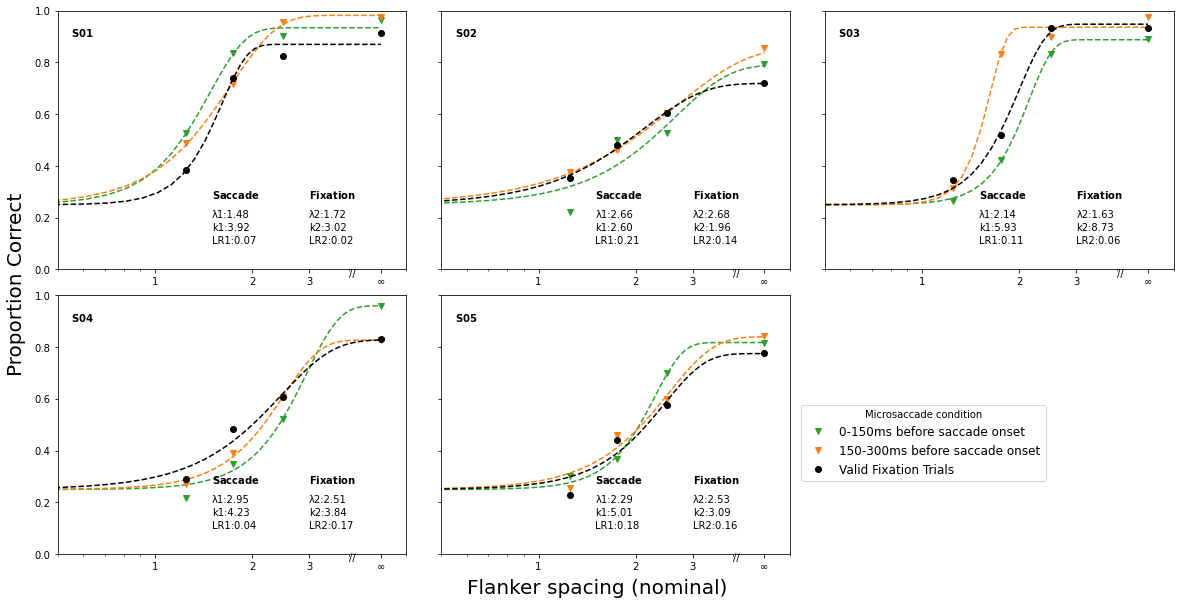

In [161]:
## We subdivide saccade trials into ones with stimuli 0-150 ms and 150-300 ms before saccade onset  
sacc0to150ms=sacc300msOnsetDF.query("-0.150<relStimTime<0")
sacc150to300ms=sacc300msOnsetDF.query("-0.300<relStimTime<-0.150")

bootstrap_fit=False
subs=behavData.subj_id.unique()
fig,ax=plt.subplots(nrows=2,ncols=3,sharey=True,figsize=(20,10))
subCounter=0
for row in ax:
    for col in row:
        if subCounter!=5:
            asub=subs[subCounter]
            # This plots the psychometric function in trials with and without microsaccades independently
            # Set whether or not to use bootstrap fit
            # First we declare the data/trials with congruent microsaccades
            dataWsacc0to150ms=sacc0to150ms.query("subj_id_x==@asub & spacing!=1.2") # to fix cases where the rel onset time is really big
            #get samples
            x_all = dataWsacc0to150ms['spacing'].unique()
            #     x_all.sort()
            y_all = dataWsacc0to150ms.groupby('spacing')['corr'].mean().values
            x_sacc0to150ms=x_all#[:-1]
            x_sacc0to150ms.sort()
            y_sacc0to150ms=y_all#[:-1]
            y_sacc0to150ms.sort()

            # First we declare the data/trials with congruent microsaccades
            dataWsacc150to300ms=sacc150to300ms.query("subj_id_x==@asub & spacing!=1.2") # to fix cases where the rel onset time is really big
            #get samples
            x_all = dataWsacc150to300ms['spacing'].unique()
            #     x_all.sort()
            y_all = dataWsacc150to300ms.groupby('spacing')['corr'].mean().values
            x_sacc150to300ms=x_all#[:-1]
            x_sacc150to300ms.sort()
            y_sacc150to300ms=y_all#[:-1]
            y_sacc150to300ms.sort()

            # second we declare the data/trials without microsaccades
            dataWOsacc=behavDataNoMicrosaccade.query("subj_id==@asub & spacing!=1.2") # to fix cases where the rel onset time is really big
            #get samples
            x_all = dataWOsacc['spacing'].unique()
            #     x_all.sort()
            y_all = dataWOsacc.groupby('spacing')['corr'].mean().values
            x_nosacc=x_all#[:-1]
            x_nosacc.sort()
            y_nosacc=y_all#[:-1]
            y_nosacc.sort()


            # REGRESSION ------------------------------------------------------------------
            p0 = [3.5, 2,0.05] #weibull                                       # guessed params
            #     p0=[-1.5,-1,1] # exponential
            w1, _ = opt.curve_fit(func_weibull, x_sacc0to150ms, y_sacc0to150ms, p0=p0)
            w2, _=opt.curve_fit(func_weibull, x_sacc150to300ms, y_sacc150to300ms, p0=p0)
            w3, _ = opt.curve_fit(func_weibull, x_nosacc, y_nosacc, p0=p0)
        #     print("Estimated Parameters:Saccade", w1)  
        #     print("Estimated Parameters:no saccade", w2)  

            unflanked_position=5
            # Model
            x_lin=np.linspace(0,unflanked_position,50) # we move the unflanked one to 6th pos to make it look nice
            y_model_sacc0to150ms = func_weibull(x_lin, *w1)
            y_model_sacc150to300ms=func_weibull(x_lin, *w2)
            y_model_nosacc= func_weibull(x_lin, *w3)

            #plot early microsaccade condition
        #     sns.pointplot(data=dataWsacc,x='spacing',y='corr',join=False,ax=col,palette=['C2'])
            col.plot(x_sacc0to150ms[:-1], y_sacc0to150ms[:-1],ls='',marker='v',color='C2',label='0-150ms before saccade onset')
            col.plot(unflanked_position,y_sacc0to150ms[-1], marker='v',color='C2')

            if bootstrap_fit==True:
                sns.lineplot(x='x_lin',y='y_model',color='C2',ci='sd',data=y_model_df.query("microsaccade_condition=='saccade' & subj==@asub"),ax=col)
            else:
                col.plot(x_lin,y_model_sacc0to150ms,ls='--',color='C2')

            # plot intermediate microsaccade condition
            col.plot(x_sacc150to300ms[:-1], y_sacc150to300ms[:-1],ls='',marker='v',color='C1',label='150-300ms before saccade onset')
            col.plot(unflanked_position,y_sacc150to300ms[-1], marker='v',color='C1')

            if bootstrap_fit==True:
                sns.lineplot(x='x_lin',y='y_model',color='C1',ci='sd',data=y_model_df.query("microsaccade_condition=='saccade' & subj==@asub"),ax=col)
            else:
                col.plot(x_lin,y_model_sacc150to300ms,ls='--',color='C1')
            #plot no saccade condtion
        #     sns.pointplot(data=dataWOsacc,x='spacing',y='corr',join=False,ax=col,palette=['k'])
            col.plot(x_nosacc[:-1], y_nosacc[:-1],ls='',marker='o',color='k',label='Valid Fixation Trials')
            col.plot(unflanked_position,y_nosacc[-1],marker='o',color='k')

            if bootstrap_fit==True:
                sns.lineplot(x='x_lin',y='y_model',color='k',ci='sd',data=y_model_df.query("microsaccade_condition=='no_saccade' & subj==@asub"),ax=col)
                col.set_xlabel('')
                col.set_ylabel('')
            else:
                col.plot(x_lin,y_model_nosacc,ls='--',color='k')
            #plot tweaks
            if subCounter==4:
                col.legend(title='Microsaccade condition',bbox_to_anchor=(1.75,0.6), prop={'size': 12})
            else:
                if bootstrap_fit==True:
                    col.get_legend().remove()
            col.set_ylim(0,1)
            col.set_xlim(0.5,6)
            col.set_xscale('log')
            col.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
            col.set_xticks([1,2,3,unflanked_position])
            col.set_xticklabels(['1','2','3','∞'])
            # We add the fit parameters inside the plot
            col.text(col.get_xlim()[0]+0.05,0.90,r"$\bf{%s}$"%asub)
            col.text(4,-0.025,'//')
            first_pos=1.5
            second_pos=3
            if bootstrap_fit==True:
                # we get the fit measures from the bootrapped DF
                w1=fit_paramsDF.query("saccade_cond=='saccade' & subj==@asub").mean()
                w2=fit_paramsDF.query("saccade_cond=='no_saccade' & subj==@asub").mean()
                col.text(first_pos,0.2,"λ1:%.2f"%w1[0])
                col.text(second_pos,0.2,"λ2:%.2f"%w2[0])
                col.text(first_pos,0.15,"k1:%.2f"%w1[1])
                col.text(second_pos,0.15,"k2:%.2f"%w2[1])
                col.text(first_pos,0.1,"LR1:%.2f"%w1[2])
                col.text(second_pos,0.1,"LR2:%.2f"%w2[2])
            else:
                col.text(first_pos,0.2,"λ1:%.2f"%w1[0])
                col.text(second_pos,0.2,"λ2:%.2f"%w2[0])
                col.text(first_pos,0.15,"k1:%.2f"%w1[1])
                col.text(second_pos,0.15,"k2:%.2f"%w2[1])
                col.text(first_pos,0.1,"LR1:%.2f"%w1[2])
                col.text(second_pos,0.1,"LR2:%.2f"%w2[2])
            col.text(first_pos,0.275,r"$\bf{Saccade}$")
            col.text(second_pos,0.275,r"$\bf{Fixation}$")
            subCounter+=1
        else:
            fig.delaxes(col)
fig.text(0.09,0.5,"Proportion Correct",size=20,va='center',rotation=90)
fig.text(0.5,0.07,"Flanker spacing (nominal)",size=20,ha='center')
fig.subplots_adjust(wspace=0.1,hspace=0.1)
#fig.tight_layout()
# if bootstrap_fit==True:
#     plt.savefig('..\Plots\psychometricFunction_hue_microsaccadeCondition_bootstrap_fit_2by4.svg',format='svg',dpi=1200)
# else:
#     plt.savefig('..\Plots\psychometricFunction_hue_microsaccadeCondition_2by4.svg',format='svg',dpi=1200)

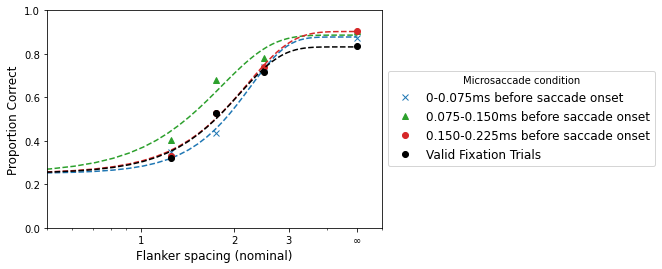

In [37]:
## We subdivide saccade trials into ones with stimuli 0-150 ms and 150-300 ms before saccade onset  
bootstrap_fit=False
startTimeStamp=[0,-0.075,-0.150]
endTimeStamp=[-0.075,-0.150,-0.225]


fig=plt.figure()
 
ax = Subplot(fig, 111)
fig.add_subplot(ax)

num_steps=len(startTimeStamp)
for i in range(num_steps):
    startTime=startTimeStamp[i]
    endTime=endTimeStamp[i]
    # we filter saccade data
    saccDF_timeFiltered=sacc300msOnsetDF.query("@endTime<relStimTime<@startTime")

    # We set color, marker & label based on condition
    if i==0:
        colorType='C0'
        markerLabel='%d-%.3fms before saccade onset'%(startTime,endTime*-1)
        markerType='x'
    elif i==1:
        colorType='C2'
        markerLabel='%.3f-%.3fms before saccade onset'%(startTime*-1,endTime*-1)
        markerType='^'
    elif i==2:
        colorType='C3'
        markerLabel='%.3f-%.3fms before saccade onset'%(startTime*-1,endTime*-1)
        markerType='o'
    elif i==3:
        colorType='C4'
        markerLabel='%.3f-%.3fms before saccade onset'%(startTime*-1,endTime*-1)
        markerType='v'
    elif i==4:
        colorType='C5'
        markerLabel='%.3f-%.3fms before saccade onset'%(startTime*-1,endTime*-1)
        markerType='+'
    
    # This plots the psychometric function in trials with and without microsaccades independently
    # Set whether or not to use bootstrap fit
    # First we declare the data/trials with congruent microsaccades
    dataWSacc=saccDF_timeFiltered # to fix cases where the rel onset time is really big
    #get samples
    x_all = dataWSacc['spacing'].unique()
    #     x_all.sort()
    y_all = dataWSacc.groupby('spacing')['corr'].mean().values
    x_sacc=x_all#[:-1]
    x_sacc.sort()
    y_sacc=y_all#[:-1]
    y_sacc.sort()


    # second we declare the data/trials without microsaccades
    if i==num_steps-1:
        dataWOsacc=behavDataNoMicrosaccade # to fix cases where the rel onset time is really big
        #get samples
        x_all = dataWOsacc['spacing'].unique()
        #     x_all.sort()
        y_all = dataWOsacc.groupby('spacing')['corr'].mean().values
        x_nosacc=x_all#[:-1]
        x_nosacc.sort()
        y_nosacc=y_all#[:-1]
        y_nosacc.sort()


    # REGRESSION ------------------------------------------------------------------
    p0 = [3.5, 2,0.05] #weibull                                       # guessed params
    #     p0=[-1.5,-1,1] # exponential
    w1, _ = opt.curve_fit(func_weibull, x_sacc, y_sacc, p0=p0)
    if i==num_steps-1:
        w2, _ = opt.curve_fit(func_weibull, x_nosacc, y_nosacc, p0=p0)
    #     print("Estimated Parameters:Saccade", w1)  
    #     print("Estimated Parameters:no saccade", w2)  

    unflanked_position=5
    # Model
    x_lin=np.linspace(0,unflanked_position,50) # we move the unflanked one to 6th pos to make it look nice
    y_model_sacc = func_weibull(x_lin, *w1)
    if i==num_steps-1:
        y_model_nosacc= func_weibull(x_lin, *w2)

    #plot early microsaccade condition
    #     sns.pointplot(data=dataWsacc,x='spacing',y='corr',join=False,ax=col,palette=['C2'])
    ax.plot(x_sacc[:-1], y_sacc[:-1],ls='',marker=markerType,color=colorType,label=markerLabel)
    ax.plot(unflanked_position,y_sacc[-1], marker=markerType,color=colorType)

    if bootstrap_fit==True:
        sns.lineplot(x='x_lin',y='y_model',color='C2',ci='sd',data=y_model_df.query("microsaccade_condition=='saccade'"))
    else:
        ax.plot(x_lin,y_model_sacc,ls='--',color=colorType)

    #plot no saccade condtion
    #     sns.pointplot(data=dataWOsacc,x='spacing',y='corr',join=False,ax=col,palette=['k'])
    if i==num_steps-1:
        ax.plot(x_nosacc[:-1], y_nosacc[:-1],ls='',marker='o',color='k',label='Valid Fixation Trials')
        ax.plot(unflanked_position,y_nosacc[-1],marker='o',color='k')

        if bootstrap_fit==True:
            sns.lineplot(x='x_lin',y='y_model',color='k',ci='sd',data=y_model_df.query("microsaccade_condition=='no_saccade'"))
            plt.set_xlabel('')
            plt.set_ylabel('')
        else:
            ax.plot(x_lin,y_model_nosacc,ls='--',color='k')
        #plot tweaks
    ax.legend(title='Microsaccade condition',bbox_to_anchor=(1,0.75), prop={'size': 12})

    ax.set_ylim(0,1)
    ax.set_xlim(0.5,6)
    ax.set_xscale('log')
    ax.set_ylabel("Proportion Correct",size=12)
    ax.set_xlabel("Flanker spacing (nominal)",size=12)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xticks([1,2,3,unflanked_position])
    ax.set_xticklabels(['1','2','3','∞'])
    # We add the fit parameters inside the plot

#fig.tight_layout()
# if bootstrap_fit==True:
#     plt.savefig('..\Plots\psychometricFunction_hue_microsaccadeCondition_bootstrap_fit_2by4.svg',format='svg',dpi=1200)
# else:
#     plt.savefig('..\Plots\psychometricFunction_hue_microsaccadeCondition_2by4.svg',format='svg',dpi=1200)

## Z Score Vs. Spacing Plots

In [149]:
###### subs=behavData.subj_id.unique()
spacing_list=sacc300msOnsetDF.spacing.unique()
zScore_sacc=[]
zScore_noSacc=[]
total_iter=len(spacing_list) * 7
counter=1
for asub in subs:
    for aspacing in spacing_list:
        print("%d/%d"%(counter,total_iter),end='\r')
        #No Saccade Trials
        data_nosacc=behavDataNoMicrosaccade.query("subj_id==@asub & spacing==@aspacing")['corr']
        propVals=bootstrap_corr_to_propCor(data_nosacc)
        zScores=bootstrap_corr_to_z(data_nosacc)
        tempDF_nosacc=pd.DataFrame(np.column_stack((propVals,zScores)),columns=['propCorr','zScores'])
        tempDF_nosacc['subj']=asub
        tempDF_nosacc['spacing']=aspacing
        zScore_noSacc.append(tempDF_nosacc)
        #Saccade Trials
        data_sacc=sacc300msOnsetDF.query("subj_id_x==@asub & spacing==@aspacing")['corr']
        propVals=bootstrap_corr_to_propCor(data_sacc)
        zScores=bootstrap_corr_to_z(data_sacc)
        tempDF_sacc=pd.DataFrame(np.column_stack((propVals,zScores)),columns=['propCorr','zScores'])
        tempDF_sacc['subj']=asub
        tempDF_sacc['spacing']=aspacing
        zScore_sacc.append(tempDF_sacc)
        counter+=1
zScore_sacc=pd.concat(zScore_sacc)
zScore_noSacc=pd.concat(zScore_noSacc)

In [150]:
zScore_sacc.to_csv("zScore_sacc.csv")
zScore_noSacc.to_csv("ZScore_nosacc.csv")

c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
c:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

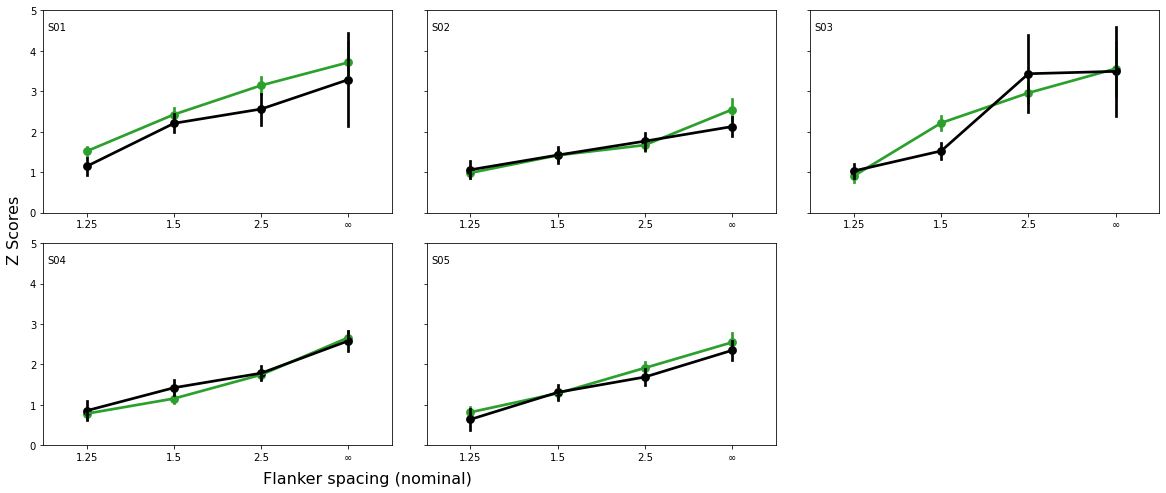

In [151]:
subs=behavData.subj_id.unique()
fig,axs=plt.subplots(2,3,figsize=(20,8),sharey=True)
subCounter=0
for row in axs:
    for col in row:
        if subCounter!=5:
            asub=subs[subCounter]
            df1=zScore_sacc.query("subj==@asub")
            df2=zScore_noSacc.query("subj==@asub")
            df1['trialCond']='saccTrials'
            df2['trialCond']='fixTrials'
            sns.pointplot(data=df1,hue='trialCond',x='spacing',y='zScores',palette=['C2'],ci='sd',ax=col)
            sns.pointplot(data=df2,hue='trialCond',x='spacing',y='zScores',ci='sd',ax=col,palette=['k'])
            leg_handles = col.get_legend_handles_labels()[0]
            if subCounter==6:
                col.legend(leg_handles, ['Microsaccade Condition','Fixation Condition'], title='Microsaccade Condition',bbox_to_anchor=(1.65,0.75))
            else:
                col.get_legend().remove()
            col.yaxis.label.set_visible(False)
            col.xaxis.label.set_visible(False)
            col.set_ylim(0,5)
            col.text(col.get_xlim()[0]+0.05,col.get_ylim()[1]-0.5,asub)
            #col.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
            col.set_xticks([0,1,2,3])
            col.set_xticklabels(['1.25','1.5','2.5','∞'])
            #col.grid()
            subCounter+=1
        else:
            fig.delaxes(col)
fig.text(0.1,0.5,"Z Scores",size=16,va='center',rotation=90)
fig.text(0.35,0.06,"Flanker spacing (nominal)",size=16,ha='center')   
fig.subplots_adjust(wspace=0.1,hspace=0.15)
# fig.tight_layout()
plt.savefig("..\Plots\ZScoreVspacing_bySubj.pdf",dpi=1200,bbox_tight='inches')

## We create binned data frame based on stimulus onset time relative to saccade onset

In [152]:
# Microsaccade metrics binned with respect to stimulus onset

# we would mostly alter this to adjust the step size and smoothing window limit
stepSize=0.050 #seconds
binSize=0.100

startPt=-0.300
endPt=0.050
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
subs=sacc300msOnsetDF.subj_id_x.unique()
numelements=len(subs)*len(bins)
counter=1
# we create the necessary lists
# first we create lists for the experiment conditions
# First for the performance df
# No microsaccade condition list
BinDataPerf_sacc_combined=[]
BinDataPerf_nosacc_combined=[]
for asub in subs:
    for abin in bins:
        start=abin-binWidth
        end=abin+binWidth
        # Trials with microsaccades present
        print('%d/%d'%(counter,numelements),end='\r')
        perfDF=sacc300msOnsetDF.query("@start<relStimTime<@end & subj_id_x==@asub").drop_duplicates(subset=['code'])
        perfDF['binPt']=abin
        BinDataPerf_sacc_combined.append(perfDF)
        counter+=1
    #Trials W/o microsaccades 
    datanoSacc=behavDataNoMicrosaccade.query("subj_id==@asub")
    BinDataPerf_nosacc_combined.append(datanoSacc)
                    
BinDataPerf_sacc_combined=pd.concat(BinDataPerf_sacc_combined)
BinDataPerf_nosacc_combined=pd.concat(BinDataPerf_nosacc_combined)

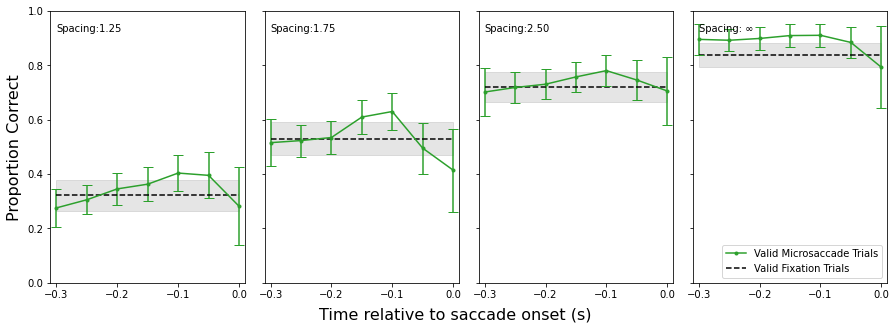

In [154]:
fig,axs=plt.subplots(nrows=1,ncols=4,sharey=True,figsize=(15,5))
spacings= [  1.25,1.75,2.50,100.]
subs=BinDataPerf_sacc_combined.subj_id_x.unique()

colCounter=0
for col in axs:    
    aspacing=spacings[colCounter]
    #Microsaccade Condition
    subs_list=['S01','S02','S03','S04','S05','S06','S07']
    query_string="spacing==@aspacing & subj_id_x==@subs_list"
    df2_mean=BinDataPerf_sacc_combined.query(query_string).groupby(['binPt'])['corr'].mean().reset_index()
    # Compute CI
    df2_std=BinDataPerf_sacc_combined.query(query_string).groupby(['binPt'])['corr'].std().reset_index()
    df2_count=BinDataPerf_sacc_combined.query(query_string).groupby(['binPt'])['corr'].count().reset_index()
    x2=df2_std['binPt']
    ci2=1.96 * (df2_std['corr'])/np.sqrt(df2_count['corr']) 
    col.plot(df2_mean['binPt'],df2_mean['corr'],label='Valid Microsaccade Trials',color='C2',marker='.')
    #col.fill_between(x2,(df2_mean['corr']+ci2),(df2_mean['corr']-ci2),color='C2',alpha=0.1)
    col.errorbar(df2_mean['binPt'],df2_mean['corr'],yerr=ci2,color='C2',ls = 'none',capsize = 5)

    #No saccade condition
    query_string="spacing==@aspacing & subj_id==@subs_list"
    df3_mean=BinDataPerf_nosacc_combined.query(query_string)['corr'].mean()
    # Compute CI
    df3_std=BinDataPerf_nosacc_combined.query(query_string)['corr'].std()
    df3_count=BinDataPerf_nosacc_combined.query(query_string)['corr'].count()
    ci3=1.96 * (df3_std)/np.sqrt(df3_count) 
    xvalues=np.linspace(startPt,0,5)
    col.hlines(xmin=startPt,xmax=0,y=df3_mean,label='Valid Fixation Trials',color='k',linestyle='--')
    col.fill_between(xvalues,(df3_mean+ci3),(df3_mean-ci3),color='k',alpha=0.1)
    col.set_xlim(startPt-0.010,0.010)
    col.set_ylim(0,1)
    if colCounter==3:
        col.legend(loc='lower right')
    if aspacing!=100:
        col.text(col.get_xlim()[0]+0.01,col.get_ylim()[1]-0.075,"Spacing:%.2f"%(aspacing))
    else:
        col.text(col.get_xlim()[0]+0.01,col.get_ylim()[1]-0.075,"Spacing: ∞")
    colCounter+=1
        
fig.subplots_adjust(hspace=0.2,wspace=0.1)
fig.text(0.085,0.5,'Proportion Correct',size=16,va='center',rotation=90)
fig.text(0.5,0.025,'Time relative to saccade onset (s)',size=16,ha='center')

plt.savefig("..\Plots\PerformanceVTime_bySpacing_1by4.svg",dpi=1200,bbox_inches='tight')